# 2019-nCoV outbreak analysis

## Background
A novel coronavirus (2019-nCoV) outbreak has been continuing in China, while a few imported cases are observed in the neighbouring countries. Although the spread across China suggests a certain amount of human-to-human transmisison, there has not been any observed in those countries which saw travel cases. This suggests that not all symptomatic cases lead to a secondary transmission, which was also the case in the past SARS/MERS outbreaks. Furthermore, even if any subclinical cases had been imported into these countries undetected, at least such cases did not contributed to secondary transmissions from which a detectable case originates.


## Model
Let $J_t$ and $I_t$ be the incidence of imported and local cases of nCoV detected in a country outside China.
Let $q_t$ be the (potentially time-dependent) detection probability of nCoV infection, which is understood as the combination of both symptomatic ratio and proper reporting, and $s_\tau$ be the distribution of the serial interval (i.e. time between the linked infection pairs) of nCoV.

Assuming that the risk of importing an nCoV case follows an exponential hazard function, reflecting an ongoing outbreak in China as of February 2020, the overall (including those undetected) number of imported cases $j_t$ is given as 
$$
j_t\sim \mathrm{Pois}(\lambda_t), \\
\lambda_t=\lambda_0\exp(r t)
$$

We model the offspring distribution of nCoV by a negative binomial distribution $\mathrm{NB}\left(k,\frac{k}{R_0+k}\right)$, where $R$ is the mean (i.e. the basic reproduction number) and $k$ is the overdispersion parameter. The reproductive property of the negative binomial distriubution assures that the number of secondary infections caused by the overall infector at time $t$ follows $\mathrm{NB}\left(k(i_t+j_t),\frac{k}{R_0+k}\right)$, and we assume these offsprings are distributed on the timeline $t$ according to the serial interval distribution $s_\tau$.

The renewal process is thus represented as
$$
i_t \sim \sum_{\tau=1}^\infty \mathrm{Binom}\left(\mathrm{NB}\left(k(i_{t-\tau}+j_{t-\tau}),\frac{k}{R_0+k}\right),s_\tau \right).
$$
Note here that the sum of distributions denotes the distribution of the summed probabilistic variables.

The observation of cases is assumed to follow the binomial sampling:
$$
I_t\sim \mathrm{Binom}(i_t,q_t), \\
J_t\sim \mathrm{Binom}(j_t,q_t)
$$

# Data

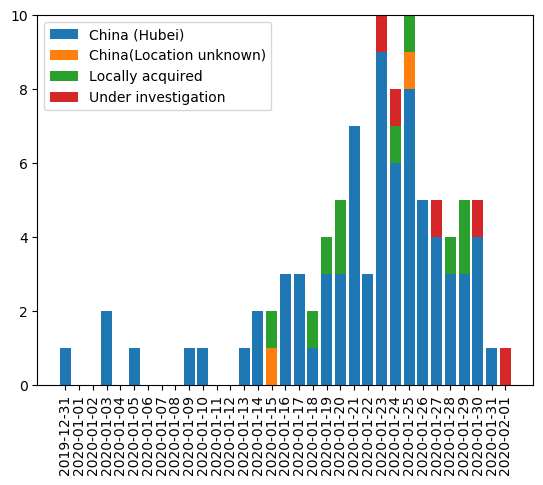

In [334]:
using DataFrames, Dates, PyPlot
# Imported and local cases outside China
# Source (accessed 4/2/2020): https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200204-sitrep-15-ncov.pdf
dates=Date("2019-12-31"):Day(1):Date("2020-2-1")
china_hubei  =[1,0,0,2,0,1,0,0,0,1,1,0,0,1,2,0,3,3,1,3,3,7,3,9,6,8,5,4,3,3,4,1,0]
china_unknown=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0]
localcases   =[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,2,0,0,0,1,1,0,0,1,2,0,0,0]
underinv     =[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,1,0,1]
casedata=DataFrame([dates,china_hubei,china_unknown,localcases,u_inv], [:date,:china_hubei,:china_unknown,:loc,:underinv])
barplots=PyPlot.bar.(Ref(1:length(casedata.date)),[Vector(casedata[:,c]) for c in 2:5],0.8,[cumsum(hcat(zeros(Int,length(casedata.date)),Matrix(casedata[:,2:5])),dims=2)[:,c] for c in 1:4])
PyPlot.xticks(1:length(casedata.date),dates,rotation="vertical")
PyPlot.legend(getindex.(barplots,1),["China (Hubei)","China(Location unknown)","Locally acquired","Under investigation"]);

In [650]:
initdate=Date("2019-9-13")
# Possible (earliest bound of) the estimted start of the outbreak
# Source: http://virological.org/t/preliminary-phylogenetic-analysis-of-11-ncov2019-genomes-2020-01-19/329
timelines=initdate:Day(1):Date("2020-2-3")
const tlen=length(timelines)
imported=zeros(Int,tlen)
loc=zeros(Int,tlen)
datesid=findall(x->x in dates,timelines)
imported[datesid].=casedata.china_hubei.+casedata.china_unknown
loc[datesid].=casedata.loc
observed=(imported=imported,loc=loc)

(imported = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  9, 5, 4, 3, 3, 4, 1, 0, 0, 0], loc = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  1, 0, 0, 1, 2, 0, 0, 0, 0, 0])

## Setups

In [551]:
# Packages
using Mamba, Distributions
# Distributions
NBmu(mu,k)=NegativeBinomial(k,mu/(mu+k))
Gmusd(mu,sd)=Gamma(mu^2/sd^2, sd^2/mu)
module DSI
using Distributions
struct DiscreteSerialInterval{T<:NamedTuple,F<:AbstractFloat, D<:Distribution}
    params::T; dist::D; distvec::Vector{F}
end
end
function DSIconstruct(distconstructor,params,tlen)
    dist=distconstructor(params...)
    distvec=cdf.(dist,0:tlen) |> diff
    DSI.DiscreteSerialInterval(params,dist,distvec)
end
SIparams=(μ=7.0,σ=3.0)
SIdist=Gmusd(SIparams...)
serialint=DSIconstruct(Gamma,NamedTuple{(:α,:θ)}(params(SIdist)),tlen)

# utils
function sysresample(weights)
    size=length(weights)
    weights=weights/sum(weights) # normalise
    cumweights=cumsum(weights)
    randomiser=floor.(Int,cumweights.*size.+rand())
    freqs=randomiser.-[0; randomiser[1:end-1]]
    return(reduce(vcat,fill.(1:size,freqs)))
end

discreteapproxsampler (generic function with 2 methods)

## Simulation functions

In [602]:
using Distributions, StatsFuns, StatsBase, SpecialFunctions
function smcinfness!(infness::NamedTuple{(:imported,:loc),T} where T,lochazard::Matrix{<:AbstractFloat},cases::NamedTuple{(:imported,:loc),T} where T,nbparm,gtimevec)
    nsample=size(infness.imported,2)
    lweights=zeros(nsample)
    lkh=zeros(nsample)
    α,p=nbparm
    θ=(1-p)/p
    for t in 1:length(cases.loc)
        if cases.imported[t] != 0
            # draw gamma: total offsprings
            infness.imported[t,:].=rand(Gamma(α*cases.imported[t],θ),nsample)
            #distribute infness on timeline
            @views lochazard[t+1:end,:].+=infness.imported[t:t,:].*gtimevec[1:length(cases.loc)-t]
        end
        if cases.loc[t] != 0
            # draw gamma: total offsprings
            infness.loc[t,:].=rand(Gamma(α*cases.loc[t],θ),nsample)
            #distribute infness on timeline
            @views lochazard[t+1:end,:].+=infness.loc[t:t,:].*gtimevec[1:length(cases.loc)-t]
        end
        
        # filter particle
        @views lweights.+=logpdf.(Poisson.(lochazard[t,:]),cases.loc[t])
        #if(2logsumexp(weights)-logsumexp(2 .*weights)< log(nsample)-log(2))
            # resample

            lkh.+=lweights
        if all(lweights.≤-Inf) break end
            lweights.-=maximum(lweights)
            newid=sysresample(exp.(lweights))
            @views infness.imported[1:t,:].=infness.imported[1:t,newid]
            @views infness.loc[1:t,:].=infness.loc[1:t,newid]
            @views lochazard[1:t,:].=lochazard[1:t,newid]
            @views lkh.=lkh[newid]
            lweights.=0.0
        #end
    end
    return(lkh)
end

function infnessgibbs!(infness,lochazard,nsamples,branchdist,gtimedist,tlen,cases)
    # infness
    infness_pts=(imported=zeros(tlen,nsamples), loc=zeros(tlen,nsamples))
    lochazard_pts=zeros(tlen,nsamples)
    gtimevec=diff(cdf.(gtimedist,0:tlen))
    counts=0
    lls=zeros(nsamples)
    while true
        infness_pts.imported.=0.0
        infness_pts.loc.=0.0
        lochazard_pts.=0.0
        lls.=smcinfness!(infness_pts,lochazard_pts,cases,params(branchdist),gtimevec)
        counts+=1
        if sum(lls)>-Inf break end
        if counts>100 error("infness could not be sampled in 100 SMC iterations") end
    end
    # sample from lls
    sampleid=sample(Weights(exp.(lls.-maximum(lls))))
    if isnan(sampleid) sanpleid=1 end
    @views infness.imported.=infness_pts.imported[:,sampleid]
    @views infness.loc.=infness_pts.loc[:,sampleid]
    @views lochazard.=lochazard_pts[:,sampleid]
    lls
end
module ApproxSampler
using Distributions, SpecialFunctions
struct Vars_t{F<:AbstractFloat,T,I<:Integer}
    infness::F
    hazard::F
    nbparm::T
    observed::I
    detectprob::F
end
function poisgammacond(vars::Vars_t,x::I where I<:Integer)
    if vars.observed==0 && x==0 return(exp(-vars.hazard)*typeof(vars.infness)(vars.infness==0.0)) end
    α,p=vars.nbparm
    θ=(1-p)/p
    poismean=(1-vars.detectprob)*vars.hazard*(vars.infness/θ)^α
    pdf(Poisson(poismean),x)/gamma(α*(vars.observed+x))
end
function discreteapproxsampler(densityfunc,paramobj,upper,tol=1e-4)
    u=rand()
    sumcdf=0.0
    Δcdf=0.0
    xmax=0
    while xmax≤upper ||  Δcdf/sumcdf>tol
        Δcdf=densityfunc(paramobj,xmax)
        sumcdf+=Δcdf
        xmax+=1
    end
    funccdf=0.0
    xsample=0
    for x in 0:xmax-1
        xsample=x
        funccdf+=densityfunc(paramobj,x)/sumcdf
        if funccdf≥u break end
    end
    return(xsample)
end
end
function casescondsampler!(cases,infness,hazard,nbparm,observed,detectprob)
    for tag in (:imported,:loc)
        cases[tag].=ApproxSampler.discreteapproxsampler.(
            ApproxSampler.poisgammacond,
            ApproxSampler.Vars_t.(infness[tag],hazard[tag],Ref(nbparm),observed[tag],detectprob),
            hazard[tag]
        )
    end
end
function casesgibbs()
end

casesgibbs (generic function with 1 method)

In [667]:
# test simulation run
nb=NBmu(2,3)
gt=Gmusd(7,1)
R0=2
k=0.5
λ0=0.02
r=0.01
q=0.1

cases=(imported=observed.imported,loc=observed.loc)
importhazard=[λ0*exp(r*t) for t in 1:tlen]
lochazard=ones(tlen)
hazard=(imported=importhazard,loc=lochazard)
infness=(imported=observed.imported.+0.0,loc=observed.loc.+0.0)
@time infnessgibbs!(infness,hazard.loc,500,nb,gt,tlen,cases);
@time casescondsampler!(cases,infness,hazard,params(nb),observed,q)

  0.103414 seconds (81.28 k allocations: 136.623 MiB, 19.55% gc time)
  0.000085 seconds (5 allocations: 192 bytes)


## MCMC sampling

In [11]:
# unknown variables: λ, i, j, R₀, k, q
parms=Dict{Symbol,Any}(
    :λ₀=>[0.1],
    :r=>[0.1],
    :R₀=>[1.0],
    :k=>[0.5],
    :q=>ones(float64,tlen)
)
priors=Dict{Symbol,Any}()
for parname in keys(parms)
    priors[parname]=Stochastic(1,()->Uniform(0,5))
end
priors[:q]=Stochastic(1,()->Uniform(0,1))

inputs=Dict{Symbol,Any}(
    :SI=serialint
    :casedata=casedata
    :zerotrick=0.0
)

inits=copy(parms)
inits=[inits]

model=Model(
    j=Stochastic(1,
        (λ₀,r,q)->Poisson.(λ₀*exp.(r.*(1:tlen))) #conditioned to J: Gibbs
    ),
    i=Stochastic(1,
        (j,R₀,k)->0.0# NegativeBinomial.(j.*k,k/(R₀+k)): renewal process
    ),
    
    llcase=Logical(
        ()->0.0
        , false
    ),
    llctrl=Logical(
        (hhCtrl_i,hhCtrl_n,Λc,βh)->begin
            Rmat=fill(βh[5],5,5)
            Rmat[1:2,1:2].=βh[1]
            Rmat[3:4,3:4].=βh[2]
            Rmat[4,1:2]=Rmat[1:2,4].=βh[3]
            Rmat[5,5]=βh[4]
            global counter+=1
            global chk=(Rmat,Λc,βh)
            if(counter%100==0) println(counter) end
            return(hetLK.ll(hhCtrl_i,hhCtrl_n,Λc.value,Rmat,0.5))
        end
        , false
    ),
    lltotal=Logical((llcase,llctrl,invtemp)->(llcase+llctrl)*invtemp),
    pseudodata=Stochastic((lltotal)->mb.LogPosterior(lltotal.value),false),
    exnodes...
)
global counter=0
setsamplers!(model,[AMM(collect(keys(parms)),Matrix{Float64}(I,10,10).*0.001)])
sim1 = mcmc(model, inputs, inits, 3000, burnin=2000, thin=2, chains=1)

In [ ]:
# util functions
function importandbranch!(cases::NamedTuple{(:imported,:loc,:infness,:hazard),NTuple{4,Vector{R}}} where R<:Real,importhazard,nbparm,gtimevec,atleastone=false)
    for t in 1:length(cases.loc)
        if sum(vec[t] for vec in cases)+importhazard[t] == 0 continue end
        
        # draw cases
        cases.imported[t]+=rand(Poisson(importhazard[t]))
        cases.loc[t]+=rand(Poisson(cases.hazard[t]))
        currinfs=cases.imported[t]+cases.loc[t]
        
        # draw gamma: total offsprings
        if currinfs!=0
            α,p=nbparm
            θ=(1-p)/p
            cases.infness[t]=rand(Gamma(α*currinfs,θ))
            #distribute infness on timeline
            cases.hazard[t+1:end].+=cases.infness[t].*gtimevec[1:length(cases.loc)-t]
            else cases.infness[t]=0.0
        end
        
        # if conditioned that infections ≧ 1
        if atleastone
            plusoneat=t+ceil(Int,sample(1:length(gtimevec),Weights(gtimevec)))
            if plusoneat<=length(cases.loc) cases.loc[plusoneat]+=1 end
            atleastone=false
        end
    end
end
# clusters generator
function importcluster(nsample,branchdist,gtimedist,tlen,importhazard)
    labels=(:imported,:loc,:infness,:hazard)
    samples=[NamedTuple{labels}(collect((zeros(Float64,tlen) for j in 1:4))) for i in 1:nsample]
    gtimevec=diff(cdf.(gtimedist,0:tlen))
    importandbranch!.(samples,Ref(importhazard),Ref(params(branchdist)),Ref(gtimevec))
    return(samples)
end